In [1]:
import pandas as pd
import math
from datetime import datetime
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import seaborn as sns
import scipy
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d %H:%M:%S') 
dnorte = pd.read_csv('sst-poligono-norte.csv', parse_dates=['Image_Datetime'], index_col='Image_Datetime',date_parser=dateparse) 
dcentro = pd.read_csv('sst-poligono-centro.csv', parse_dates=['Image_Datetime'], index_col='Image_Datetime',date_parser=dateparse)
dsul = pd.read_csv('sst-poligono-sul.csv', parse_dates=['Image_Datetime'], index_col='Image_Datetime',date_parser=dateparse)
dnorte = dnorte.resample('D').mean()
dcentro = dcentro.resample('D').mean()
dsul = dsul.resample('D').mean()
dsul.head()

C:\Users\xavie\anaconda3\envs\timeseries\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


,ID,mean,stdDev,sum
Image_Datetime,,,,
2002-07-04,1.0,25.405301,0.418657,7.573316e+07
2002-07-05,1.0,25.751801,0.438114,1.848684e+08
2002-07-06,1.0,25.540597,0.551288,1.765313e+08
2002-07-07,1.0,25.928837,0.510939,2.377606e+08
2002-07-08,1.0,25.243048,0.434463,7.046492e+07


In [3]:
sst_mean_norte = dnorte['mean'].interpolate()
sst_mean_centro = dcentro['mean'].interpolate()
sst_mean_sul = dsul['mean'].interpolate()

sst_std_norte = dnorte['stdDev'].interpolate()
sst_std_centro = dcentro['stdDev'].interpolate()
sst_std_sul = dsul['stdDev'].interpolate()

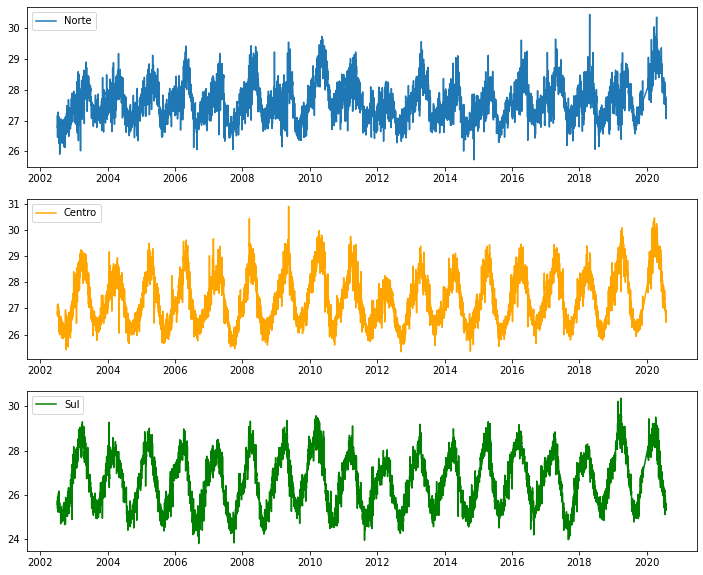

In [4]:
plt.figure(figsize=(12,10))
plt.subplot(311) 
plt.plot(sst_mean_norte)
plt.legend(['Norte'])
plt.subplot(312) 
plt.plot(sst_mean_centro, color = 'orange')
plt.legend(['Centro'])
plt.subplot(313) 
plt.plot(sst_mean_sul, color = 'green')
plt.legend(['Sul'], loc = 'upper left')

In [5]:
# DECOMPONDO AS SÉRIES TEMPORAIS
ts = sst_mean_norte
decomposition = seasonal_decompose(ts, period = 365) # PERIOD = 365 POIS OS DADOS SÃO DIÁRIOS
trend_norte = decomposition.trend # COMPONENTE TENDÊNCIA
seasonal_norte = decomposition.seasonal # COMPONENTE SAZONAL
residual_norte = decomposition.resid # COMPONENTE RESIDUCAL

ts = sst_mean_centro
decomposition = seasonal_decompose(ts, period = 365) 
trend_centro = decomposition.trend 
seasonal_centro = decomposition.seasonal 
residual_centro = decomposition.resid

ts = sst_mean_sul
decomposition = seasonal_decompose(ts, period = 365) 
trend_sul = decomposition.trend 
seasonal_sul = decomposition.seasonal 
residual_sul = decomposition.resid

In [6]:
# REMOVENDO A SAZONALIDADE (SUBTRAINDO COMPONENTE SAZONAL DA SÉRIE ORIGINAL)
sst_corr_norte = sst_mean_norte - seasonal_norte
sst_corr_centro = sst_mean_centro - seasonal_centro
sst_corr_sul = sst_mean_sul - seasonal_sul

mean_norte = np.average(sst_corr_norte)
mean_centro = np.average(sst_corr_centro)
mean_sul = np.average(sst_corr_sul)

std_norte = np.average(sst_std_norte)
std_centro = np.average(sst_std_centro)
std_sul = np.average(sst_std_sul)

In [7]:
# CALCULANDO AS ANOMALIAS DE TEMPERATURA
# FORMA SIMPLES CONSIDERANDO APENAS A VARIAÇÃO EM RELAÇÃO A MÉDIA (MAS TAMBÉM PODERIAMOS CONSIDERAR O DESVIO PADRÃO)
sst_anomalia_norte = sst_corr_norte - np.average(sst_corr_norte)
sst_anomalia_centro = sst_corr_centro - np.average(sst_corr_centro)
sst_anomalia_sul = sst_corr_sul - np.average(sst_corr_sul)

# OBTENDO SOMENTE AS ANOMALIAS POSITIVAS
sst_anomalia_norte[sst_anomalia_norte < 0] = 0
sst_anomalia_centro[sst_anomalia_centro < 0] = 0
sst_anomalia_sul[sst_anomalia_sul < 0] = 0

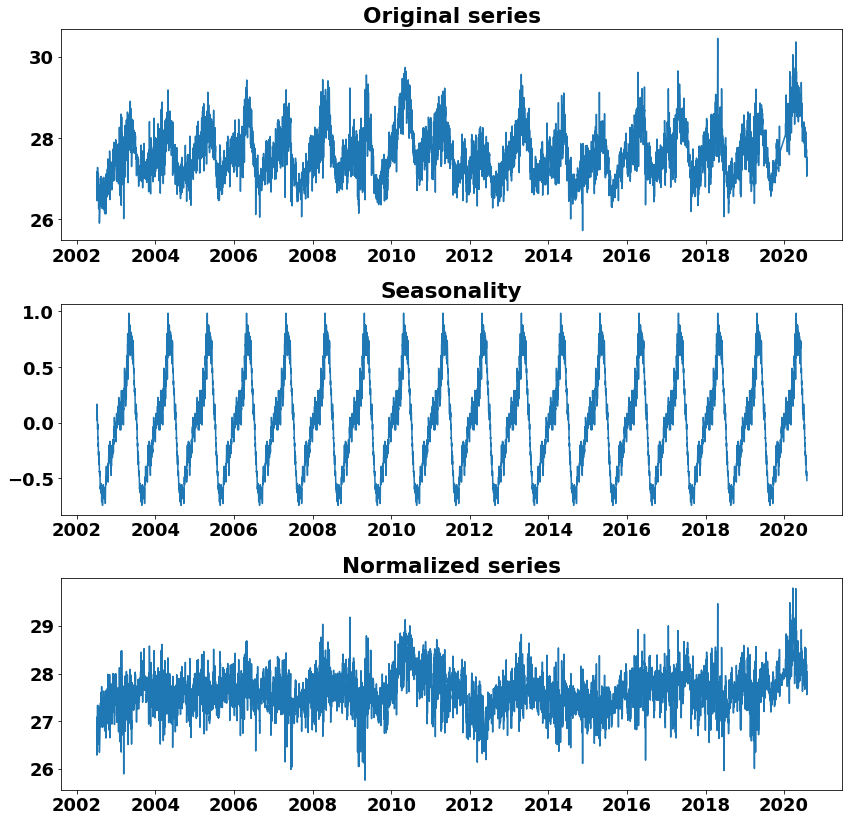

In [15]:
plt.rcParams.update({'font.size': 18})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.figure(figsize=(14,14))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.3)
plt.subplot(311) 
plt.plot(sst_mean_norte)
plt.title('Original series', fontweight='bold')
plt.subplot(312) 
plt.plot(seasonal_norte)
plt.title('Seasonality', fontweight='bold')
plt.subplot(313) 
plt.plot(sst_corr_norte)
plt.title('Normalized series', fontweight='bold')
plt.show()
#plt.savefig('seasonal_example.png',dpi=100, bbox_inches='tight')

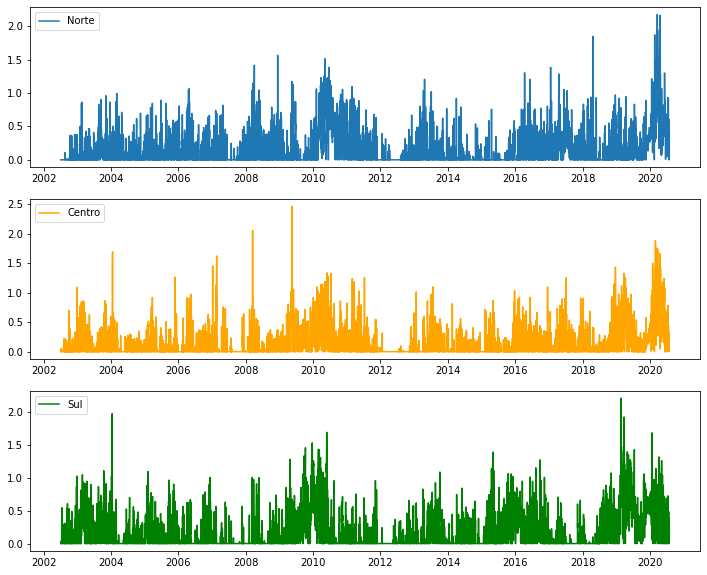

In [9]:
plt.figure(figsize=(12,10))
plt.subplot(311) 
plt.plot(sst_anomalia_norte)
plt.legend(['Norte'], loc = 'upper left')
plt.subplot(312) 
plt.plot(sst_anomalia_centro, color = 'orange')
plt.legend(['Centro'], loc = 'upper left')
plt.subplot(313) 
plt.plot(sst_anomalia_sul, color = 'green')
plt.legend(['Sul'], loc = 'upper left')

In [10]:
print('Temperatura média da série original: ', np.average(sst_mean_centro))
print('Temperatura média da série normalizada: ', np.average(sst_corr_centro))
print('Temperatura acima do 98 percentil: ', np.percentile(sst_corr_centro, 98))
heatwaves = np.where(sst_corr_sul > np.percentile(sst_corr_sul, 98))
heatwaves = np.asarray(heatwaves)
heatwaves = heatwaves.tolist()
heatwaves = heatwaves[0]
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

consecutive(heatwaves)
#print(type(teste))

#print('Dias com temperatura acima do heatwaves 99 percentil:', heatwaves)
#sst_corr_sul.iloc[2730:2742]
#seasonal_norte.iloc[6469:6479]

# HEATWAVES POLÍGONO NORTE
#mhw_norte_2010_05 = sst_corr_norte.iloc[2895:2901] 
#mhw_norte_2010_06 = sst_corr_norte.iloc[2895:2901]
#mhw_norte_2020_03 = sst_corr_norte.iloc[6466:6479]


Temperatura média da série original:  27.388065544139426
Temperatura média da série normalizada:  27.390308136583823
Temperatura acima do 98 percentil:  28.29361836359694


[array([177]),
 array([236]),
 array([468]),
 array([552]),
 array([559]),
 array([947, 948]),
 array([2489]),
 array([2631]),
 array([2640]),
 array([2645, 2646]),
 array([2654, 2655]),
 array([2716]),
 array([2721, 2722, 2723, 2724, 2725]),
 array([2727, 2728, 2729, 2730, 2731, 2732]),
 array([2735]),
 array([2741, 2742, 2743, 2744]),
 array([2748]),
 array([2783]),
 array([2789, 2790, 2791]),
 array([2794, 2795, 2796]),
 array([2800, 2801, 2802]),
 array([2804]),
 array([2814]),
 array([2816, 2817, 2818]),
 array([2825]),
 array([2843]),
 array([2882, 2883, 2884, 2885, 2886]),
 array([2889]),
 array([4113]),
 array([4673]),
 array([4683]),
 array([4691]),
 array([4697]),
 array([4855]),
 array([4886]),
 array([4906]),
 array([5093]),
 array([5153]),
 array([5199]),
 array([5972]),
 array([6070]),
 array([6076]),
 array([6078]),
 array([6080, 6081, 6082, 6083]),
 array([6085, 6086]),
 array([6088]),
 array([6092, 6093, 6094, 6095, 6096, 6097, 6098]),
 array([6105]),
 array([6107]),
 

In [11]:
# ENCONTRANDO AS MÉDIAS DE SAZONALIDADE PARA O PERÍODO DE HEATWAVES
seasonal_mean = np.average(seasonal_norte.iloc[6495:6500])
seasonal_mean2 = np.average(seasonal_centro.iloc[6495:6500])
# MHW 2020-03-20 A 2020-03-29
print('Temperatura média da série original: ', np.average(sst_mean_sul))
print('Temperatura média da série normalizada: ', (np.average(sst_corr_centro)+(np.average(sst_corr_centro))))
print('Temperatura acima do 90 percentil: ', np.percentile(sst_corr_sul, 90))
print('Delta_T: ', np.percentile(sst_corr_norte, 90) - np.average(sst_corr_norte))
print('Delta_T: ', ((np.percentile(sst_corr_norte, 90) - np.average(sst_corr_norte))+(np.percentile(sst_corr_centro, 90) - np.average(sst_corr_centro)))/2)
print('Temperatura média sazonal: ', seasonal_mean)
print((seasonal_mean+seasonal_mean2)/2)

Temperatura média da série original:  26.666006911542635
Temperatura média da série normalizada:  54.780616273167645
Temperatura acima do 90 percentil:  27.25753259558882
Delta_T:  0.5135091287858273
Delta_T:  0.4948361510041881
Temperatura média sazonal:  0.5654553759466043
0.9104645417543481


In [12]:
print('Temperatura média da série original: ', np.average(sst_mean_sul))
print('Temperatura média da série normalizada: ', (((np.average(sst_corr_centro)+(np.average(sst_corr_centro)))/2)))
print('Temperatura acima do 98 percentil: ', ((np.percentile(sst_corr_norte, 98)+(np.percentile(sst_corr_centro, 98)))/2))
print('Temperatura acima do 90 percentil: ', ((np.percentile(sst_corr_norte, 90)+(np.percentile(sst_corr_centro, 90)))/2))
print('Delta_T: ', np.percentile(sst_corr_norte, 90) - np.average(sst_corr_norte))
print('Delta_T: ', ((np.percentile(sst_corr_norte, 90) - np.average(sst_corr_norte))+(np.percentile(sst_corr_centro, 90) - np.average(sst_corr_centro)))/2)

Temperatura média da série original:  26.666006911542635
Temperatura média da série normalizada:  27.390308136583823
Temperatura acima do 98 percentil:  28.411854363887397
Temperatura acima do 90 percentil:  27.99972558492612
Delta_T:  0.5135091287858273
Delta_T:  0.4948361510041881


In [13]:
# ENCONTRANDO OS DADOS ACIMA DE 99.5 PERCENTIL
sst_percentile_norte = sst_corr_norte
sst_percentile_centro = sst_corr_centro
sst_percentile_sul = sst_corr_sul

dummy_norte = sst_percentile_norte
dummy_centro = sst_percentile_centro
dummy_sul = sst_percentile_sul

In [14]:
sst_percentile_norte[sst_percentile_norte < np.percentile(dummy_norte, 98)] = 0
sst_percentile_centro[sst_percentile_centro < np.percentile(dummy_centro, 98)] = 0
sst_percentile_sul[sst_percentile_sul < np.percentile(dummy_sul, 98)] = 0

In [15]:
# ANOMALIAS DOS 99.5 PERCENTILS
sst_anomalia_percentile_norte = sst_percentile_norte - mean_norte
sst_anomalia_percentile_centro = sst_percentile_centro - mean_centro
sst_anomalia_percentile_sul = sst_percentile_sul - mean_sul
sst_anomalia_percentile_norte[sst_anomalia_percentile_norte < 0] = 0
sst_anomalia_percentile_centro[sst_anomalia_percentile_centro < 0] = 0
sst_anomalia_percentile_sul[sst_anomalia_percentile_sul < 0] = 0

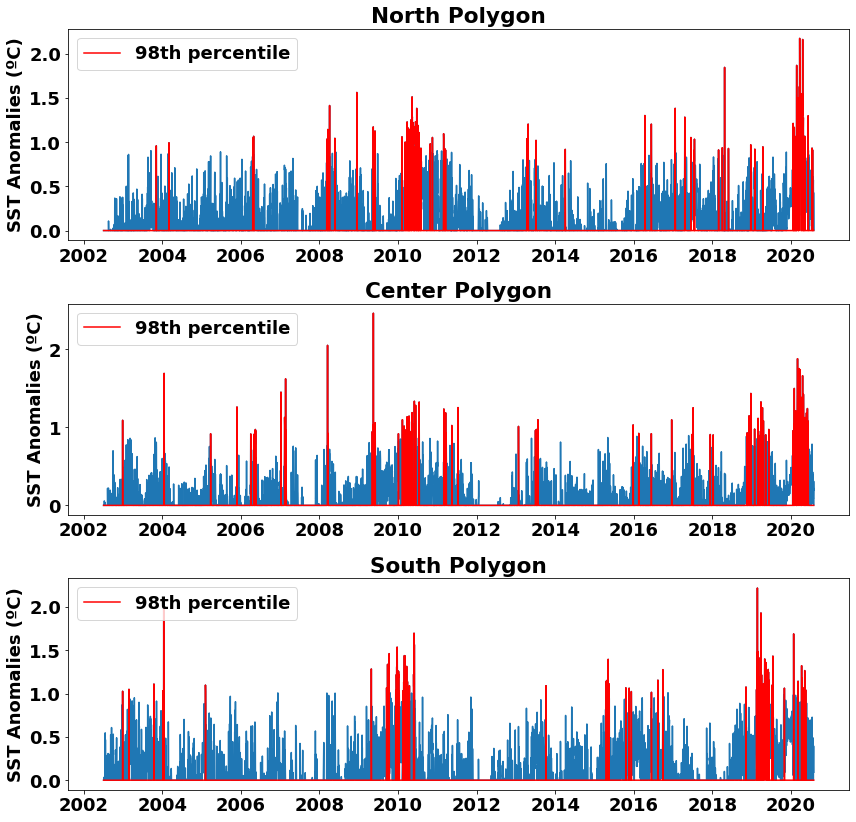

In [16]:
plt.rcParams.update({'font.size': 18})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.figure(figsize=(14,14))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.3)
plt.subplot(311) 
plt.plot(sst_anomalia_norte)
plt.plot(sst_anomalia_percentile_norte, color = 'red', label = '98th percentile')
plt.legend(loc = 'upper left')
plt.title('North Polygon', fontweight='bold')
plt.ylabel('SST Anomalies (ºC)')

plt.subplot(312) 
plt.plot(sst_anomalia_centro)
plt.plot(sst_anomalia_percentile_centro, color = 'red', label = '98th percentile')
plt.title('Center Polygon', fontweight='bold')
plt.legend(loc = 'upper left')
plt.ylabel('SST Anomalies (ºC)')

plt.subplot(313) 
plt.plot(sst_anomalia_sul)
plt.plot(sst_anomalia_percentile_sul, color = 'red', label = '98th percentile')
plt.title('South Polygon', fontweight='bold')
plt.legend(loc = 'upper left')
plt.ylabel('SST Anomalies (ºC)')
plt.savefig('sst_anomalies.png',dpi=100, bbox_inches='tight')